# 0716325 曾正豪

In [1]:
import csv
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt

In [32]:
x = []
x_numer = []
y_binary = []
y_5_level = []
first = 0

with open('student-mat.csv', newline='') as csvfile:
  rows = csv.reader(csvfile, delimiter = ';')
  for row in rows:
    if first == 0:
        first = 1
        continue
    
    x_numer.append([row[2], row[6], row[7], row[12], row[13], row[14]])
    x_numer[-1].extend(row[23:31])
    x.append(row[0:2])
    x[-1].extend(row[3:6])
    x[-1].extend(row[8:12])
    x[-1].extend(row[15:23])
    
    G3 = int(row[-1])
    if G3 >= 10:
        y_binary.append('PASS')
    else:
        y_binary.append('FAIL')
    
    if G3 >= 16:
        y_5_level.append('A')
    elif G3 >= 14:
        y_5_level.append('B')
    elif G3 >= 12:
        y_5_level.append('C')
    elif G3 >= 10:
        y_5_level.append('D')
    else:
        y_5_level.append('F')
#print(x_numer[1])
#print(x[1])
#print(len(y_binary), len(y_5_level))
y_binary = np.array(y_binary)
y_5_level = np.array(y_5_level)

enc = OneHotEncoder(handle_unknown='ignore', sparse = False)
enc.fit(x)
x = enc.transform(x)
x = np.append(x, x_numer, axis=1)
x = np.array(x, dtype=np.float64)

In [3]:
pca = PCA(n_components=40)

# PCA + Decision Tree

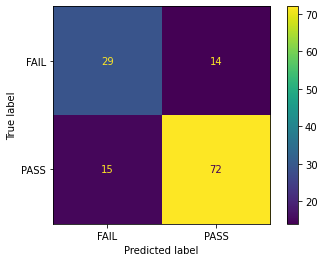

              precision    recall  f1-score   support

        FAIL       0.65      0.68      0.66       130
        PASS       0.84      0.82      0.83       265

    accuracy                           0.77       395
   macro avg       0.75      0.75      0.75       395
weighted avg       0.78      0.77      0.78       395



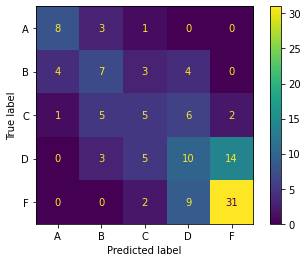

              precision    recall  f1-score   support

           A       0.56      0.60      0.58        40
           B       0.38      0.38      0.38        60
           C       0.29      0.24      0.27        62
           D       0.35      0.31      0.33       103
           F       0.64      0.72      0.68       130

    accuracy                           0.48       395
   macro avg       0.44      0.45      0.45       395
weighted avg       0.46      0.48      0.47       395



In [4]:
kf = KFold(n_splits=3)
kf.get_n_splits(x)
true_bin_class = []
true_5l_class = []
pred_bin_class = []
pred_5l_class = []

CMbinary_list = np.zeros((2,2)).astype(int)
CM5_level_list = np.zeros((5,5)).astype(int)

for train_index, test_index in kf.split(x):
    X_train, X_test = x[train_index], x[test_index]
    y_binary_train, y_binary_test = y_binary[train_index], y_binary[test_index]
    y_5_level_train, y_5_level_test = y_5_level[train_index], y_5_level[test_index]

    pca.fit(X_train)

    X_train = pca.transform(X_train)
    X_test  = pca.transform(X_test)

    decision_tree_bin = tree.DecisionTreeClassifier()
    decision_tree_5l  = tree.DecisionTreeClassifier()

    decision_tree_bin = decision_tree_bin.fit(X_train, y_binary_train)
    decision_tree_5l  = decision_tree_5l.fit(X_train, y_5_level_train)

    y_binary_pred  = decision_tree_bin.predict(X_test)
    y_5_level_pred = decision_tree_5l.predict(X_test)

    true_bin_class.extend(y_binary_test)
    true_5l_class.extend(y_5_level_test)
    pred_bin_class.extend(y_binary_pred)
    pred_5l_class.extend(y_5_level_pred)

#binary 
CMbinary_list = confusion_matrix(true_bin_class, pred_bin_class) // 3
report = classification_report(true_bin_class, pred_bin_class)
ConfusionMatrixDisplay(confusion_matrix=CMbinary_list, display_labels=decision_tree_bin.classes_).plot()
plt.show()
print(report)

#5 level 
CMbinary_list = confusion_matrix(true_5l_class, pred_5l_class) // 3
report = classification_report(true_5l_class, pred_5l_class)
ConfusionMatrixDisplay(confusion_matrix=CMbinary_list, display_labels=decision_tree_5l.classes_).plot()
plt.show()
print(report)



# without PCA + Decision Tree

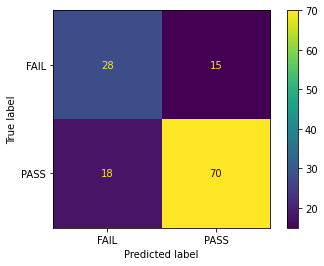

              precision    recall  f1-score   support

        FAIL       0.61      0.65      0.63       130
        PASS       0.82      0.80      0.81       265

    accuracy                           0.75       395
   macro avg       0.71      0.72      0.72       395
weighted avg       0.75      0.75      0.75       395



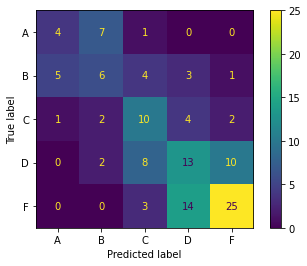

              precision    recall  f1-score   support

           A       0.39      0.35      0.37        40
           B       0.36      0.33      0.35        60
           C       0.39      0.52      0.44        62
           D       0.38      0.39      0.38       103
           F       0.65      0.58      0.61       130

    accuracy                           0.46       395
   macro avg       0.43      0.43      0.43       395
weighted avg       0.47      0.46      0.46       395



In [5]:
kf = KFold(n_splits=3)
kf.get_n_splits(x)
true_bin_class = []
true_5l_class = []
pred_bin_class = []
pred_5l_class = []

CMbinary_list = np.zeros((2,2)).astype(int)
CM5_level_list = np.zeros((5,5)).astype(int)

for train_index, test_index in kf.split(x):
    X_train, X_test = x[train_index], x[test_index]
    y_binary_train, y_binary_test = y_binary[train_index], y_binary[test_index]
    y_5_level_train, y_5_level_test = y_5_level[train_index], y_5_level[test_index]

    decision_tree_bin = tree.DecisionTreeClassifier()
    decision_tree_5l  = tree.DecisionTreeClassifier()

    decision_tree_bin = decision_tree_bin.fit(X_train, y_binary_train)
    decision_tree_5l  = decision_tree_5l.fit(X_train, y_5_level_train)

    y_binary_pred  = decision_tree_bin.predict(X_test)
    y_5_level_pred = decision_tree_5l.predict(X_test)

    true_bin_class.extend(y_binary_test)
    true_5l_class.extend(y_5_level_test)
    pred_bin_class.extend(y_binary_pred)
    pred_5l_class.extend(y_5_level_pred)

#binary 
CMbinary_list = confusion_matrix(true_bin_class, pred_bin_class) // 3
report = classification_report(true_bin_class, pred_bin_class)
ConfusionMatrixDisplay(confusion_matrix=CMbinary_list, display_labels=decision_tree_bin.classes_).plot()
plt.show()
print(report)

#5 level 
CMbinary_list = confusion_matrix(true_5l_class, pred_5l_class) // 3
report = classification_report(true_5l_class, pred_5l_class)
ConfusionMatrixDisplay(confusion_matrix=CMbinary_list, display_labels=decision_tree_5l.classes_).plot()
plt.show()
print(report)



# PCA + Random Forest

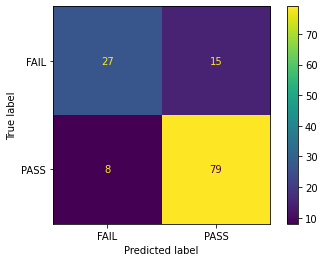

              precision    recall  f1-score   support

        FAIL       0.76      0.64      0.69       130
        PASS       0.84      0.90      0.87       265

    accuracy                           0.82       395
   macro avg       0.80      0.77      0.78       395
weighted avg       0.81      0.82      0.81       395



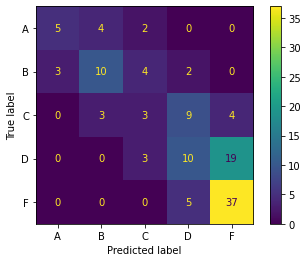

              precision    recall  f1-score   support

           A       0.61      0.42      0.50        40
           B       0.55      0.50      0.52        60
           C       0.21      0.15      0.17        62
           D       0.37      0.31      0.34       103
           F       0.61      0.86      0.71       130

    accuracy                           0.51       395
   macro avg       0.47      0.45      0.45       395
weighted avg       0.48      0.51      0.48       395



In [6]:
kf = KFold(n_splits=3)
kf.get_n_splits(x)
true_bin_class = []
true_5l_class = []
pred_bin_class = []
pred_5l_class = []

CMbinary_list = np.zeros((2,2)).astype(int)
CM5_level_list = np.zeros((5,5)).astype(int)

for train_index, test_index in kf.split(x):
    X_train, X_test = x[train_index], x[test_index]
    y_binary_train, y_binary_test = y_binary[train_index], y_binary[test_index]
    y_5_level_train, y_5_level_test = y_5_level[train_index], y_5_level[test_index]

    pca.fit(X_train)

    X_train = pca.transform(X_train)
    X_test  = pca.transform(X_test)

    random_forest_bin = RandomForestClassifier()
    random_forest_5l  = RandomForestClassifier()

    random_forest_bin = random_forest_bin.fit(X_train, y_binary_train)
    random_forest_5l  = random_forest_5l.fit(X_train, y_5_level_train)

    y_binary_pred  = random_forest_bin.predict(X_test)
    y_5_level_pred = random_forest_5l.predict(X_test)

    true_bin_class.extend(y_binary_test)
    true_5l_class.extend(y_5_level_test)
    pred_bin_class.extend(y_binary_pred)
    pred_5l_class.extend(y_5_level_pred)

#binary 
CMbinary_list = confusion_matrix(true_bin_class, pred_bin_class) // 3
report = classification_report(true_bin_class, pred_bin_class)
ConfusionMatrixDisplay(confusion_matrix=CMbinary_list, display_labels=random_forest_bin.classes_).plot()
plt.show()
print(report)

#5 level 
CMbinary_list = confusion_matrix(true_5l_class, pred_5l_class) // 3
report = classification_report(true_5l_class, pred_5l_class)
ConfusionMatrixDisplay(confusion_matrix=CMbinary_list, display_labels=random_forest_5l.classes_).plot()
plt.show()
print(report)



# without PCA + Random Forest

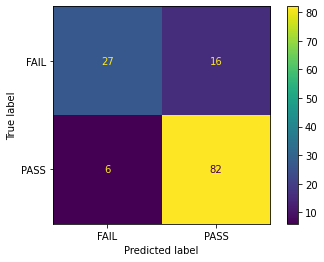

              precision    recall  f1-score   support

        FAIL       0.81      0.62      0.70       130
        PASS       0.83      0.93      0.88       265

    accuracy                           0.83       395
   macro avg       0.82      0.78      0.79       395
weighted avg       0.83      0.83      0.82       395



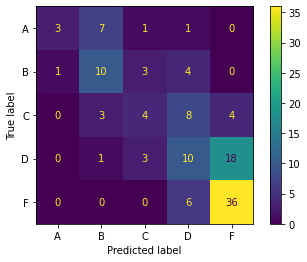

              precision    recall  f1-score   support

           A       0.64      0.23      0.33        40
           B       0.46      0.50      0.48        60
           C       0.36      0.23      0.28        62
           D       0.34      0.31      0.32       103
           F       0.60      0.85      0.70       130

    accuracy                           0.49       395
   macro avg       0.48      0.42      0.42       395
weighted avg       0.48      0.49      0.47       395



In [7]:
kf = KFold(n_splits=3)
kf.get_n_splits(x)
true_bin_class = []
true_5l_class = []
pred_bin_class = []
pred_5l_class = []

CMbinary_list = np.zeros((2,2)).astype(int)
CM5_level_list = np.zeros((5,5)).astype(int)

for train_index, test_index in kf.split(x):
    X_train, X_test = x[train_index], x[test_index]
    y_binary_train, y_binary_test = y_binary[train_index], y_binary[test_index]
    y_5_level_train, y_5_level_test = y_5_level[train_index], y_5_level[test_index]

    random_forest_bin = RandomForestClassifier()
    random_forest_5l  = RandomForestClassifier()

    random_forest_bin = random_forest_bin.fit(X_train, y_binary_train)
    random_forest_5l  = random_forest_5l.fit(X_train, y_5_level_train)

    y_binary_pred  = random_forest_bin.predict(X_test)
    y_5_level_pred = random_forest_5l.predict(X_test)

    true_bin_class.extend(y_binary_test)
    true_5l_class.extend(y_5_level_test)
    pred_bin_class.extend(y_binary_pred)
    pred_5l_class.extend(y_5_level_pred)

#binary 
CMbinary_list = confusion_matrix(true_bin_class, pred_bin_class) // 3
report = classification_report(true_bin_class, pred_bin_class)
ConfusionMatrixDisplay(confusion_matrix=CMbinary_list, display_labels=random_forest_bin.classes_).plot()
plt.show()
print(report)

#5 level 
CMbinary_list = confusion_matrix(true_5l_class, pred_5l_class) // 3
report = classification_report(true_5l_class, pred_5l_class)
ConfusionMatrixDisplay(confusion_matrix=CMbinary_list, display_labels=random_forest_5l.classes_).plot()
plt.show()
print(report)



# Random Forest with 3 different numbers of trees

Random Forest with 5 trees


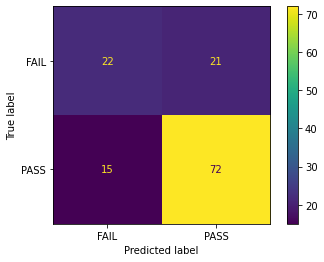

              precision    recall  f1-score   support

        FAIL       0.59      0.52      0.55       130
        PASS       0.78      0.82      0.80       265

    accuracy                           0.72       395
   macro avg       0.68      0.67      0.67       395
weighted avg       0.71      0.72      0.72       395



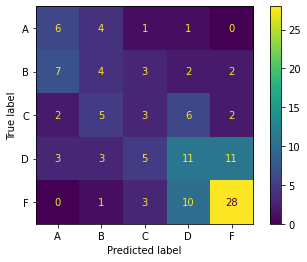

              precision    recall  f1-score   support

           A       0.33      0.50      0.40        40
           B       0.26      0.23      0.25        60
           C       0.23      0.18      0.20        62
           D       0.36      0.34      0.35       103
           F       0.62      0.65      0.64       130

    accuracy                           0.42       395
   macro avg       0.36      0.38      0.37       395
weighted avg       0.41      0.42      0.41       395

Random Forest with 10 trees


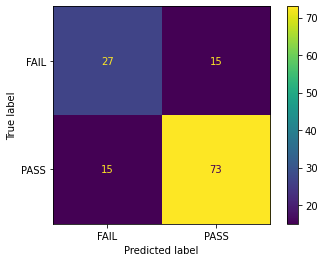

              precision    recall  f1-score   support

        FAIL       0.64      0.64      0.64       130
        PASS       0.82      0.83      0.82       265

    accuracy                           0.76       395
   macro avg       0.73      0.73      0.73       395
weighted avg       0.76      0.76      0.76       395



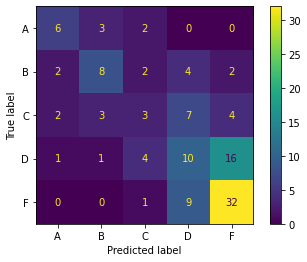

              precision    recall  f1-score   support

           A       0.49      0.47      0.48        40
           B       0.49      0.43      0.46        60
           C       0.21      0.15      0.17        62
           D       0.32      0.30      0.31       103
           F       0.58      0.74      0.65       130

    accuracy                           0.46       395
   macro avg       0.42      0.42      0.42       395
weighted avg       0.43      0.46      0.44       395

Random Forest with 50 trees


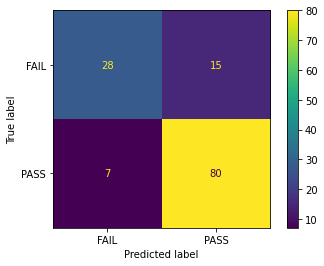

              precision    recall  f1-score   support

        FAIL       0.79      0.65      0.71       130
        PASS       0.84      0.91      0.88       265

    accuracy                           0.83       395
   macro avg       0.81      0.78      0.79       395
weighted avg       0.82      0.83      0.82       395



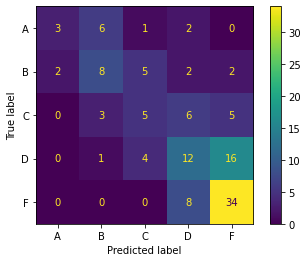

              precision    recall  f1-score   support

           A       0.52      0.28      0.36        40
           B       0.44      0.40      0.42        60
           C       0.33      0.27      0.30        62
           D       0.39      0.36      0.38       103
           F       0.60      0.79      0.68       130

    accuracy                           0.49       395
   macro avg       0.46      0.42      0.43       395
weighted avg       0.47      0.49      0.47       395



In [8]:
for tree_num in [5, 10, 50]:
    kf = KFold(n_splits=3)
    kf.get_n_splits(x)
    true_bin_class = []
    true_5l_class = []
    pred_bin_class = []
    pred_5l_class = []

    CMbinary_list = np.zeros((2,2)).astype(int)
    CM5_level_list = np.zeros((5,5)).astype(int)

    for train_index, test_index in kf.split(x):
        X_train, X_test = x[train_index], x[test_index]
        y_binary_train, y_binary_test = y_binary[train_index], y_binary[test_index]
        y_5_level_train, y_5_level_test = y_5_level[train_index], y_5_level[test_index]

        random_forest_bin = RandomForestClassifier(tree_num)
        random_forest_5l  = RandomForestClassifier(tree_num)

        random_forest_bin = random_forest_bin.fit(X_train, y_binary_train)
        random_forest_5l  = random_forest_5l.fit(X_train, y_5_level_train)

        y_binary_pred  = random_forest_bin.predict(X_test)
        y_5_level_pred = random_forest_5l.predict(X_test)

        true_bin_class.extend(y_binary_test)
        true_5l_class.extend(y_5_level_test)
        pred_bin_class.extend(y_binary_pred)
        pred_5l_class.extend(y_5_level_pred)
    
    print(f"Random Forest with {tree_num} trees")
    #binary 
    CMbinary_list = confusion_matrix(true_bin_class, pred_bin_class) // 3
    report = classification_report(true_bin_class, pred_bin_class)
    ConfusionMatrixDisplay(confusion_matrix=CMbinary_list, display_labels=random_forest_bin.classes_).plot()
    plt.show()
    print(report)

    #5 level 
    CMbinary_list = confusion_matrix(true_5l_class, pred_5l_class) // 3
    report = classification_report(true_5l_class, pred_5l_class)
    ConfusionMatrixDisplay(confusion_matrix=CMbinary_list, display_labels=random_forest_5l.classes_).plot()
    plt.show()
    print(report)



# PCA + KNN 

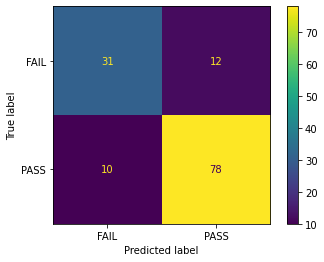

              precision    recall  f1-score   support

        FAIL       0.75      0.72      0.73       130
        PASS       0.86      0.88      0.87       265

    accuracy                           0.83       395
   macro avg       0.81      0.80      0.80       395
weighted avg       0.83      0.83      0.83       395



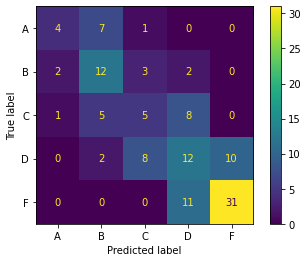

              precision    recall  f1-score   support

           A       0.52      0.30      0.38        40
           B       0.43      0.60      0.50        60
           C       0.29      0.27      0.28        62
           D       0.36      0.36      0.36       103
           F       0.74      0.72      0.73       130

    accuracy                           0.50       395
   macro avg       0.47      0.45      0.45       395
weighted avg       0.50      0.50      0.49       395



In [9]:
kf = KFold(n_splits=3)
kf.get_n_splits(x)
true_bin_class = []
true_5l_class = []
pred_bin_class = []
pred_5l_class = []

CMbinary_list = np.zeros((2,2)).astype(int)
CM5_level_list = np.zeros((5,5)).astype(int)

for train_index, test_index in kf.split(x):
    X_train, X_test = x[train_index], x[test_index]
    y_binary_train, y_binary_test = y_binary[train_index], y_binary[test_index]
    y_5_level_train, y_5_level_test = y_5_level[train_index], y_5_level[test_index]

    pca.fit(X_train)

    X_train = pca.transform(X_train)
    X_test  = pca.transform(X_test)

    KNN_bin = KNeighborsClassifier(n_neighbors=5)
    KNN_5l  = KNeighborsClassifier(n_neighbors=5)

    KNN_bin = KNN_bin.fit(X_train, y_binary_train)
    KNN_5l  = KNN_5l.fit(X_train, y_5_level_train)

    y_binary_pred  = KNN_bin.predict(X_test)
    y_5_level_pred = KNN_5l.predict(X_test)

    true_bin_class.extend(y_binary_test)
    true_5l_class.extend(y_5_level_test)
    pred_bin_class.extend(y_binary_pred)
    pred_5l_class.extend(y_5_level_pred)

#binary 
CMbinary_list = confusion_matrix(true_bin_class, pred_bin_class) // 3
report = classification_report(true_bin_class, pred_bin_class)
ConfusionMatrixDisplay(confusion_matrix=CMbinary_list, display_labels=KNN_bin.classes_).plot()
plt.show()
print(report)

#5 level 
CMbinary_list = confusion_matrix(true_5l_class, pred_5l_class) // 3
report = classification_report(true_5l_class, pred_5l_class)
ConfusionMatrixDisplay(confusion_matrix=CMbinary_list, display_labels=KNN_5l.classes_).plot()
plt.show()
print(report)



# without PCA + KNN 

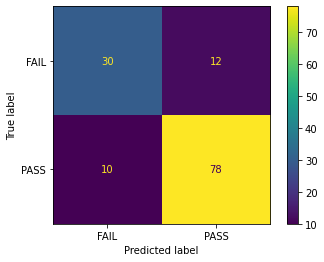

              precision    recall  f1-score   support

        FAIL       0.75      0.71      0.73       130
        PASS       0.86      0.88      0.87       265

    accuracy                           0.83       395
   macro avg       0.80      0.80      0.80       395
weighted avg       0.82      0.83      0.82       395



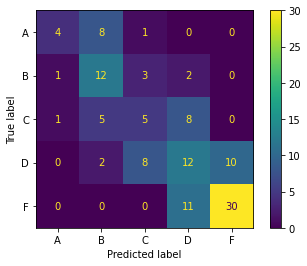

              precision    recall  f1-score   support

           A       0.55      0.30      0.39        40
           B       0.44      0.62      0.51        60
           C       0.28      0.26      0.27        62
           D       0.35      0.36      0.36       103
           F       0.73      0.71      0.72       130

    accuracy                           0.49       395
   macro avg       0.47      0.45      0.45       395
weighted avg       0.50      0.49      0.49       395



In [10]:
kf = KFold(n_splits=3)
kf.get_n_splits(x)
true_bin_class = []
true_5l_class = []
pred_bin_class = []
pred_5l_class = []

CMbinary_list = np.zeros((2,2)).astype(int)
CM5_level_list = np.zeros((5,5)).astype(int)

for train_index, test_index in kf.split(x):
    X_train, X_test = x[train_index], x[test_index]
    y_binary_train, y_binary_test = y_binary[train_index], y_binary[test_index]
    y_5_level_train, y_5_level_test = y_5_level[train_index], y_5_level[test_index]

    KNN_bin = KNeighborsClassifier(n_neighbors=5)
    KNN_5l  = KNeighborsClassifier(n_neighbors=5)

    KNN_bin = KNN_bin.fit(X_train, y_binary_train)
    KNN_5l  = KNN_5l.fit(X_train, y_5_level_train)

    y_binary_pred  = KNN_bin.predict(X_test)
    y_5_level_pred = KNN_5l.predict(X_test)

    true_bin_class.extend(y_binary_test)
    true_5l_class.extend(y_5_level_test)
    pred_bin_class.extend(y_binary_pred)
    pred_5l_class.extend(y_5_level_pred)

#binary 
CMbinary_list = confusion_matrix(true_bin_class, pred_bin_class) // 3
report = classification_report(true_bin_class, pred_bin_class)
ConfusionMatrixDisplay(confusion_matrix=CMbinary_list, display_labels=KNN_bin.classes_).plot()
plt.show()
print(report)

#5 level 
CMbinary_list = confusion_matrix(true_5l_class, pred_5l_class) // 3
report = classification_report(true_5l_class, pred_5l_class)
ConfusionMatrixDisplay(confusion_matrix=CMbinary_list, display_labels=KNN_5l.classes_).plot()
plt.show()
print(report)



# KNN with 3 different K values

KNN with 5 neighbors


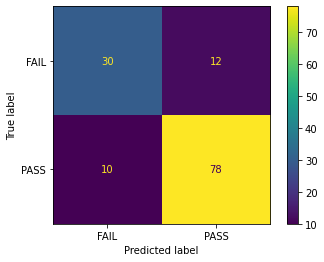

              precision    recall  f1-score   support

        FAIL       0.75      0.71      0.73       130
        PASS       0.86      0.88      0.87       265

    accuracy                           0.83       395
   macro avg       0.80      0.80      0.80       395
weighted avg       0.82      0.83      0.82       395



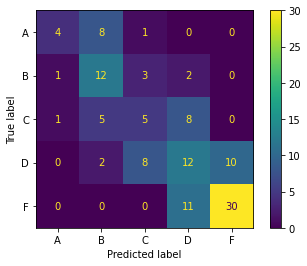

              precision    recall  f1-score   support

           A       0.55      0.30      0.39        40
           B       0.44      0.62      0.51        60
           C       0.28      0.26      0.27        62
           D       0.35      0.36      0.36       103
           F       0.73      0.71      0.72       130

    accuracy                           0.49       395
   macro avg       0.47      0.45      0.45       395
weighted avg       0.50      0.49      0.49       395

KNN with 10 neighbors


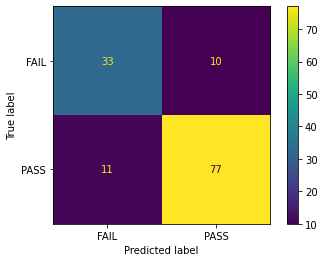

              precision    recall  f1-score   support

        FAIL       0.75      0.77      0.76       130
        PASS       0.89      0.88      0.88       265

    accuracy                           0.84       395
   macro avg       0.82      0.82      0.82       395
weighted avg       0.84      0.84      0.84       395



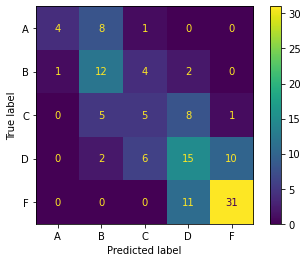

              precision    recall  f1-score   support

           A       0.67      0.30      0.41        40
           B       0.43      0.62      0.51        60
           C       0.30      0.24      0.27        62
           D       0.41      0.45      0.43       103
           F       0.73      0.72      0.73       130

    accuracy                           0.52       395
   macro avg       0.51      0.47      0.47       395
weighted avg       0.53      0.52      0.51       395

KNN with 20 neighbors


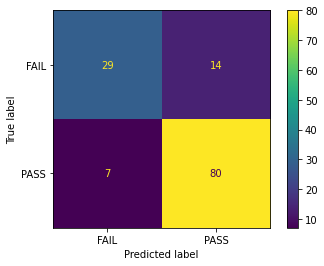

              precision    recall  f1-score   support

        FAIL       0.79      0.67      0.72       130
        PASS       0.85      0.91      0.88       265

    accuracy                           0.83       395
   macro avg       0.82      0.79      0.80       395
weighted avg       0.83      0.83      0.83       395



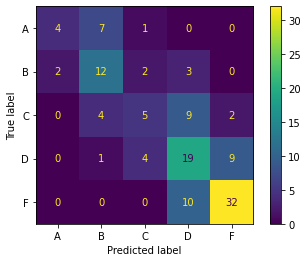

              precision    recall  f1-score   support

           A       0.59      0.33      0.42        40
           B       0.47      0.62      0.53        60
           C       0.38      0.24      0.30        62
           D       0.46      0.55      0.50       103
           F       0.75      0.75      0.75       130

    accuracy                           0.55       395
   macro avg       0.53      0.50      0.50       395
weighted avg       0.56      0.55      0.55       395



In [11]:
for k in [5, 10, 20]:
    kf = KFold(n_splits=3)
    kf.get_n_splits(x)
    true_bin_class = []
    true_5l_class = []
    pred_bin_class = []
    pred_5l_class = []

    CMbinary_list = np.zeros((2,2)).astype(int)
    CM5_level_list = np.zeros((5,5)).astype(int)

    for train_index, test_index in kf.split(x):
        X_train, X_test = x[train_index], x[test_index]
        y_binary_train, y_binary_test = y_binary[train_index], y_binary[test_index]
        y_5_level_train, y_5_level_test = y_5_level[train_index], y_5_level[test_index]

        KNN_bin = KNeighborsClassifier(n_neighbors=k)
        KNN_5l  = KNeighborsClassifier(n_neighbors=k)

        KNN_bin = KNN_bin.fit(X_train, y_binary_train)
        KNN_5l  = KNN_5l.fit(X_train, y_5_level_train)

        y_binary_pred  = KNN_bin.predict(X_test)
        y_5_level_pred = KNN_5l.predict(X_test)

        true_bin_class.extend(y_binary_test)
        true_5l_class.extend(y_5_level_test)
        pred_bin_class.extend(y_binary_pred)
        pred_5l_class.extend(y_5_level_pred)

    print(f"KNN with {k} neighbors")
    #binary 
    CMbinary_list = confusion_matrix(true_bin_class, pred_bin_class) // 3
    report = classification_report(true_bin_class, pred_bin_class)
    ConfusionMatrixDisplay(confusion_matrix=CMbinary_list, display_labels=KNN_bin.classes_).plot()
    plt.show()
    print(report)

    #5 level 
    CMbinary_list = confusion_matrix(true_5l_class, pred_5l_class) // 3
    report = classification_report(true_5l_class, pred_5l_class)
    ConfusionMatrixDisplay(confusion_matrix=CMbinary_list, display_labels=KNN_5l.classes_).plot()
    plt.show()
    print(report)



# Question

## Decision Tree: Show the prediction and reasoning of one arbitrary sample in the testing set.

data x[0]:  [[ 1.  0.  1.  0.  0.  1.  1.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.
   0.  1.  1.  0.  0.  0.  0.  1.  0.  0.  1.  1.  0.  1.  0.  1.  0.  0.
   1.  0.  1.  1.  0.  1.  0. 18.  4.  4.  2.  2.  0.  4.  3.  4.  1.  1.
   3.  6.  5.]]
Rules used to predict x[0]:
decision node 0 : (X_test[0, 56] = 9.0) <= 10.5)
decision node 1 : (X_test[0, 56] = 9.0) > 7.5)
decision node 19 : (X_test[0, 43] = 18.0) > 17.5)
decision node 67 : (X_test[0, 26] = 0.0) <= 0.5)
decision node 68 : (X_test[0, 55] = 0.0) <= 1.0)


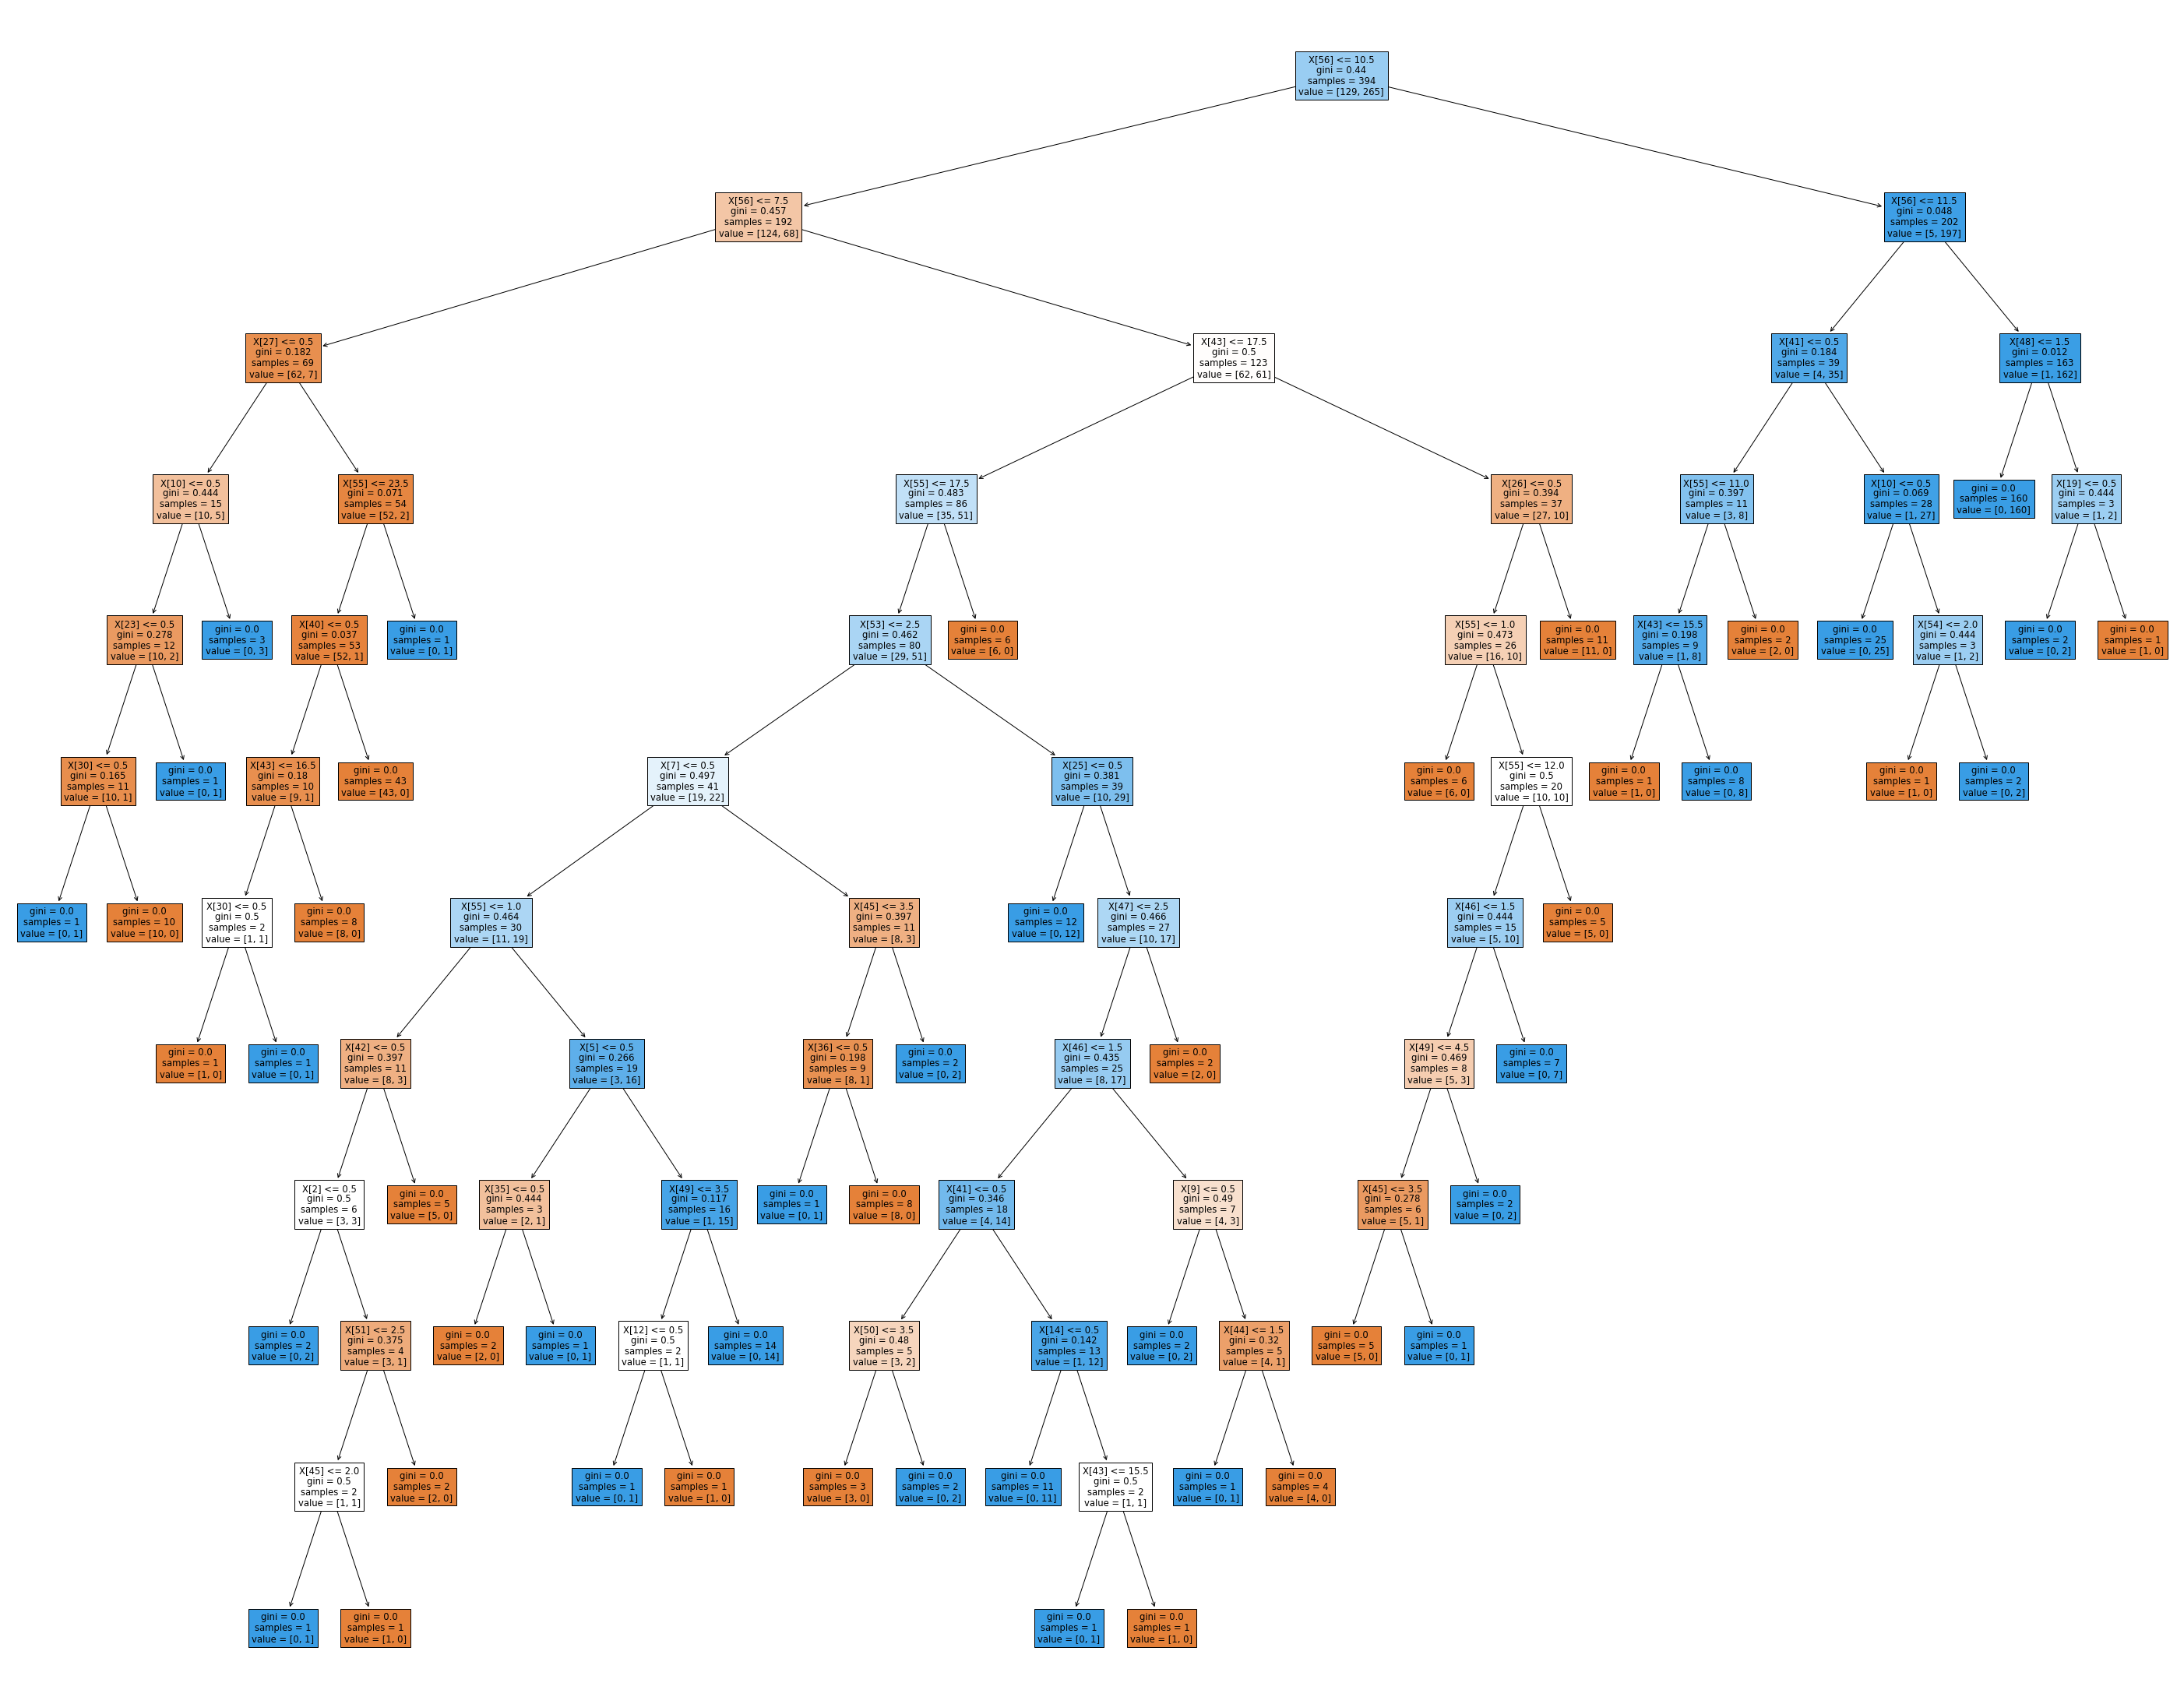

In [12]:
decision_tree_bin = tree.DecisionTreeClassifier()
decision_tree_bin = decision_tree_bin.fit(x[1:], y_binary[1:])
data = x[0].reshape(1, -1)
print("data x[0]: ", data)
y_pred  = decision_tree_bin.predict(data)
fig = plt.figure(figsize=(50,40))
tree.plot_tree(decision_tree_bin,filled=True)


node_indicator = decision_tree_bin.decision_path(X_test)
leaf_id = decision_tree_bin.apply(X_test)
feature = decision_tree_bin.tree_.feature
threshold = decision_tree_bin.tree_.threshold
sample_id = 0
# obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
node_index = node_indicator.indices[
    node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
]

print("Rules used to predict x[0]:")
for node_id in node_index:
    # continue to the next node if it is a leaf node
    if leaf_id[sample_id] == node_id:
        continue

    # check if value of the split feature for sample 0 is below threshold
    if X_test[sample_id, feature[node_id]] <= threshold[node_id]:
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print(
        "decision node {node} : (X_test[{sample}, {feature}] = {value}) "
        "{inequality} {threshold})".format(
            node=node_id,
            sample=sample_id,
            feature=feature[node_id],
            value=X_test[sample_id, feature[node_id]],
            inequality=threshold_sign,
            threshold=threshold[node_id],
        )
    )
plt.show()

## Describe the difference between boosting and bagging.
    Bagging指的是訓練集當中隨機抽取多個小數量的資料去訓練多個複雜模型，在進行預測的時候，這些模型去進行投票(classification)或取平均(regression)
    Boosting則是使用多個弱分類器來進行合成，首先會先挑出一個最佳的分類器，並在剩下的弱分類器中找出與前面的分類器互補的，這樣的步驟會持續多次直到準確率足夠
    一般來說，bagging適合用在容易overfitting的模型，boosting適合用在underfitting的模型
    
## KNN: Show the prediction and reasoning of one arbitrary sample in the testing set.

In [46]:
KNN_bin = KNeighborsClassifier(n_neighbors=40)
KNN_bin = KNN_bin.fit(x[1:], y_binary[1:])

data = x[0].reshape(1, -1)
y_pred = KNN_bin.predict_proba(data)
print(y_pred)


[[0.675 0.325]]


## Bonus: pick 2 features, draw and describe the KNN decision boundaries

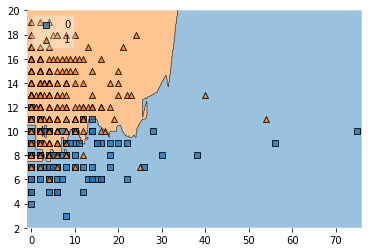

In [44]:
from mlxtend.plotting import plot_decision_regions

x_bonus = x
y_bonus = []
for i in range(55): 
    x_bonus = np.delete(x_bonus, 0, 1)
for label in y_binary:
    if label == 'PASS':
        y_bonus.append(1)
    else:
        y_bonus.append(0)
y_bonus = np.array(y_bonus)

KNN_bin = KNeighborsClassifier(n_neighbors=5)
KNN_bin = KNN_bin.fit(x_bonus, y_bonus)
plot_decision_regions(x_bonus, y_bonus, clf=KNN_bin, legend=2)
plt.show()

## In 5-Level classification, reduce the data dimension to 2 using PCA and draw a scatter plot. You have to colorize the data points based on their labels.

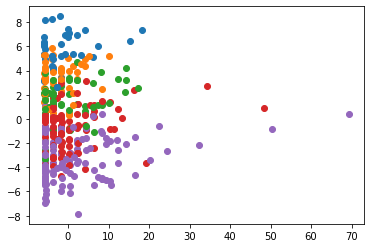

In [ ]:
pca = PCA(n_components=2)
pca.fit(x)
x_q4 = pca.transform(x)
for idx in range(len(x_q4)):
    if y_5_level[idx] == 'A':
        plt.scatter(x_q4[idx][0], x_q4[idx][1], c = '#1f77b4')
    elif y_5_level[idx] == 'B':
        plt.scatter(x_q4[idx][0], x_q4[idx][1], c = '#ff7f0e')
    elif y_5_level[idx] == 'C':
        plt.scatter(x_q4[idx][0], x_q4[idx][1], c = '#2ca02c')
    elif y_5_level[idx] == 'D':
        plt.scatter(x_q4[idx][0], x_q4[idx][1], c = '#d62728')
    else:
        plt.scatter(x_q4[idx][0], x_q4[idx][1], c = '#9467bd')
plt.show()